In [1]:
!pip install -q kaggle

In [2]:
!kaggle datasets download -d danielbacioiu/tig-aluminium-5083

Dataset URL: https://www.kaggle.com/datasets/danielbacioiu/tig-aluminium-5083
License(s): CC-BY-SA-4.0
100% 11.2G/11.2G [07:11<00:00, 30.2MB/s]
100% 11.2G/11.2G [07:11<00:00, 27.8MB/s]


In [3]:
!unzip /content/tig-aluminium-5083.zip

Streaming output truncated to the last 5000 lines.
  inflating: al5083/train/170906-151353-Al 2mm/frame_01055.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01056.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01057.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01058.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01059.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01060.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01061.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01062.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01063.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01064.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01065.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01066.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01067.png  
  inflating: al5083/train/170906-151353-Al 2mm/frame_01068.png  
  inflating: al5083/train/170906-151353

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import json
import os
import cv2
import time
from torch.optim import lr_scheduler
import copy

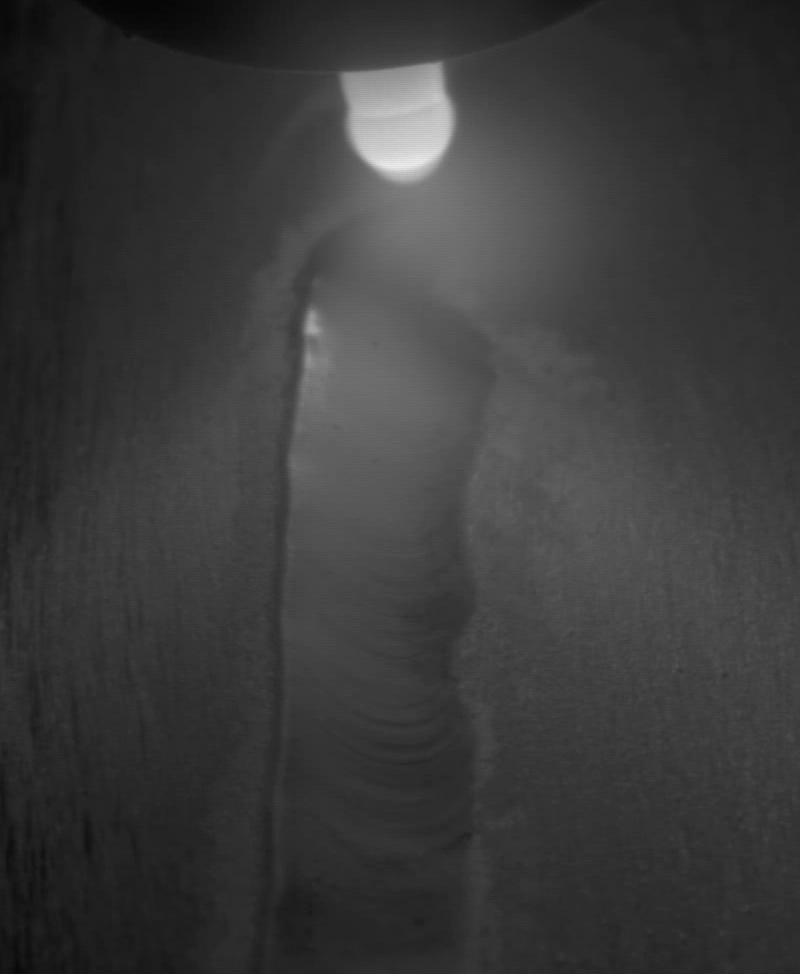

In [5]:
image = Image.open('/content/al5083/test/170904-150144-Al 2mm-part2/frame_00322.png')
image

In [6]:
image.size

(800, 974)

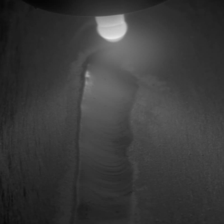

In [7]:
newimage = image.resize((224, 224))
newimage

In [8]:
newimage.size

(224, 224)

In [9]:
# Function to read JSON file
def read_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, data, base_dir, transform=None):
        self.data = data
        self.base_dir = base_dir
        self.transform = transform
        self.image_paths = list(data.keys())
        self.labels = list(data.values())

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.base_dir, self.image_paths[idx])
        label = self.labels[idx]

        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

# Function to create dataloaders
def create_dataloaders(train_data, train_base_dir, test_data, test_base_dir, batch_size=32, val_split=0.2):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Create train dataset and split into train and validation
    train_dataset = CustomDataset(train_data, train_base_dir, transform=transform)
    val_size = int(len(train_dataset) * val_split)
    train_size = len(train_dataset) - val_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    test_dataset = CustomDataset(test_data, test_base_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Main execution
train_file_path = '/content/al5083/train/train.json'
test_file_path = '/content/al5083/test/test.json'
train_base_dir = '/content/al5083/train'
test_base_dir = '/content/al5083/test'

train_data = read_json(train_file_path)
test_data = read_json(test_file_path)

train_loader, val_loader, test_loader = create_dataloaders(train_data, train_base_dir, test_data, test_base_dir, batch_size=32)

# Display the size of datasets
print("Train DataLoader size:", len(train_loader.dataset))
print("Validation DataLoader size:", len(val_loader.dataset))
print("Test DataLoader size:", len(test_loader.dataset))

Train DataLoader size: 21333
Validation DataLoader size: 5333
Test DataLoader size: 6588


In [10]:
# Calculate class weights
class_counts = [0,0,0,0,0,0]
total_samples = 0

for _, labels in train_loader:
    for label in labels:
        class_counts[label] += 1
    total_samples += labels.size(0)

class_weights = [class_counts[0]/total_samples,class_counts[1]/total_samples,class_counts[2]/total_samples,class_counts[3]/total_samples,class_counts[4]/total_samples,class_counts[5]/total_samples]
class_weights = torch.tensor(class_weights)

print("Class weights:", class_weights)


Class weights: tensor([0.3276, 0.0678, 0.2378, 0.1491, 0.1110, 0.1068])


In [11]:
sum(class_weights)

tensor(1.)

In [12]:
# Define the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)  # Adjusted for 6 classes

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 218MB/s]


In [13]:
# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc.data
                best_model_wts = copy.deepcopy(model.state_dict())
                PATH = 'model_val_acc'+str(best_acc)+'.pth'
                torch.save(model.state_dict(), PATH)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model,train_loss_history,val_loss_history,train_acc_history,val_acc_history

In [14]:
# Train the model
model,train_loss_history,val_loss_history,train_acc_history,val_acc_history = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

# Save the best model
torch.save(model.state_dict(), 'best_model.pth')

Epoch 0/9
----------
train Loss: 0.0977 Acc: 0.9577
val Loss: 0.0094 Acc: 0.9989

Epoch 1/9
----------
train Loss: 0.0063 Acc: 0.9991
val Loss: 0.0033 Acc: 0.9991

Epoch 2/9
----------
train Loss: 0.0030 Acc: 0.9998
val Loss: 0.0019 Acc: 0.9992

Epoch 3/9
----------
train Loss: 0.0018 Acc: 0.9998
val Loss: 0.0030 Acc: 0.9987

Epoch 4/9
----------
train Loss: 0.0015 Acc: 0.9999
val Loss: 0.0014 Acc: 0.9992

Epoch 5/9
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.0012 Acc: 0.9992

Epoch 6/9
----------
train Loss: 0.0013 Acc: 0.9997
val Loss: 0.0017 Acc: 0.9992

Epoch 7/9
----------
train Loss: 0.0008 Acc: 1.0000
val Loss: 0.0019 Acc: 0.9991

Epoch 8/9
----------
train Loss: 0.0007 Acc: 1.0000
val Loss: 0.0020 Acc: 0.9989

Epoch 9/9
----------
train Loss: 0.0008 Acc: 1.0000
val Loss: 0.0012 Acc: 0.9992

Training complete in 71m 3s
Best val Acc: 0.999250


In [15]:
print(train_loss_history)
print(val_loss_history)
print(train_acc_history)
print(val_acc_history)

[0.09767364176221253, 0.006274928746636766, 0.003023485297973729, 0.0018084593129701, 0.0014563955047608506, 0.0010935245382616057, 0.001279737559638183, 0.0008108893538638058, 0.0007478674610548731, 0.0007543008146188372]
[0.009431943950167677, 0.0033332927834525314, 0.0019372062801902797, 0.0029630032163027787, 0.0013640947050274444, 0.001241024499674708, 0.0016791972426070502, 0.0018799732112810097, 0.0019577914307566785, 0.0011506972335135002]
[tensor(0.9577, device='cuda:0', dtype=torch.float64), tensor(0.9991, device='cuda:0', dtype=torch.float64), tensor(0.9998, device='cuda:0', dtype=torch.float64), tensor(0.9998, device='cuda:0', dtype=torch.float64), tensor(0.9999, device='cuda:0', dtype=torch.float64), tensor(1., device='cuda:0', dtype=torch.float64), tensor(0.9997, device='cuda:0', dtype=torch.float64), tensor(1.0000, device='cuda:0', dtype=torch.float64), tensor(1.0000, device='cuda:0', dtype=torch.float64), tensor(1.0000, device='cuda:0', dtype=torch.float64)]
[tensor(0.9

In [16]:
train_acc_history_processed = []
val_acc_history_processed = []

for i in range(len(train_acc_history)):
  train_acc_history_processed.append(train_acc_history[i].detach().cpu().numpy().tolist())

for i in range(len(val_acc_history)):
  val_acc_history_processed.append(val_acc_history[i].detach().cpu().numpy().tolist())

print(train_acc_history_processed)
print(val_acc_history_processed)

[0.957718089345146, 0.9990624853513336, 0.9997656213378334, 0.9998124970702668, 0.9998593728027001, 1.0, 0.9997187456054001, 0.9999531242675667, 0.9999531242675667, 0.9999531242675667]
[0.9988749296831052, 0.9990624414025876, 0.9992499531220701, 0.9986874179636227, 0.9992499531220701, 0.9992499531220701, 0.9992499531220701, 0.9990624414025876, 0.9988749296831052, 0.9992499531220701]


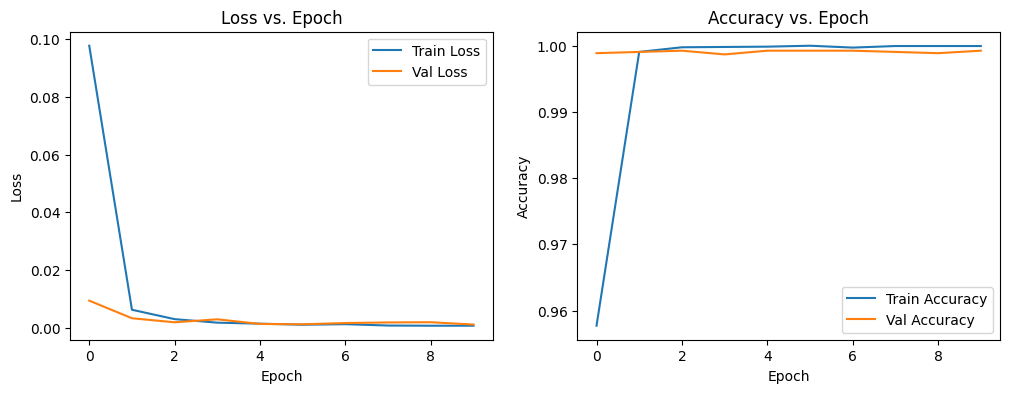

In [17]:
# Plot the loss and accuracy history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history_processed, label='Train Accuracy')
plt.plot(val_acc_history_processed, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.show()

In [18]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Evaluation on test set
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 99 %


In [19]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Evaluation on test set
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 79 %
